In [1]:
pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 21.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 34.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 58.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 62.4 MB/s eta 0:00:00


In [2]:
#Importing the required libraries
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from transformers import RobertaTokenizer
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import RobertaTokenizer, RobertaForSequenceClassification,AdamW,get_linear_schedule_with_warmup
import time
import datetime

In [3]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [4]:
#Reading the tsv file
df = pd.read_table("/content/drive/MyDrive/Homework_2/small_data/small_snli_train.tsv")
df.head()

,gold_label,sentence1_binary_parse,sentence2_binary_parse,sentence1_parse,sentence2_parse,sentence1,sentence2,captionID,pairID,label1,label2,label3,label4,label5
0,entailment,( ( ( A person ) ( on ( a horse ) ) ) ( ( jump...,"( ( A person ) ( ( ( ( is outdoors ) , ) ( on ...",(ROOT (S (NP (NP (DT A) (NN person)) (PP (IN o...,(ROOT (S (NP (DT A) (NN person)) (VP (VBZ is) ...,A person on a horse jumps over a broken down a...,"A person is outdoors, on a horse.",3416050480.jpg#4,3416050480.jpg#4r1e,entailment,NaN,NaN,NaN,NaN
1,entailment,( Children ( ( ( smiling and ) waving ) ( at c...,( There ( ( are children ) present ) ),(ROOT (NP (S (NP (NNP Children)) (VP (VBG smil...,(ROOT (S (NP (EX There)) (VP (VBP are) (NP (NN...,Children smiling and waving at camera,There are children present,2267923837.jpg#2,2267923837.jpg#2r1e,entailment,NaN,NaN,NaN,NaN
2,entailment,( ( A boy ) ( ( is ( ( jumping ( on skateboard...,( ( The boy ) ( ( does ( a ( skateboarding tri...,(ROOT (S (NP (DT A) (NN boy)) (VP (VBZ is) (VP...,(ROOT (S (NP (DT The) (NN boy)) (VP (VBZ does)...,A boy is jumping on skateboard in the middle o...,The boy does a skateboarding trick.,3691670743.jpg#0,3691670743.jpg#0r1e,entailment,NaN,NaN,NaN,NaN
3,entailment,( ( Two ( blond women ) ) ( ( are ( hugging ( ...,( There ( ( are ( women ( showing affection ) ...,(ROOT (S (NP (CD Two) (JJ blond) (NNS women)) ...,(ROOT (S (NP (EX There)) (VP (VBP are) (NP (NP...,Two blond women are hugging one another.,There are women showing affection.,4705552913.jpg#4,4705552913.jpg#4r1e,entailment,NaN,NaN,NaN,NaN
4,entailment,( ( ( A ( few people ) ) ( in ( ( ( a ( restau...,( ( The diners ) ( ( are ( at ( a restaurant )...,(ROOT (S (NP (NP (DT A) (JJ few) (NNS people))...,(ROOT (S (NP (DT The) (NNS diners)) (VP (VBP a...,"A few people in a restaurant setting, one of t...",The diners are at a restaurant.,4804607632.jpg#2,4804607632.jpg#2r1e,entailment,NaN,NaN,NaN,NaN


In [5]:
df_test = pd.read_table("/content/drive/MyDrive/Homework_2/small_data/snli_test.tsv")
df_val = pd.read_table("/content/drive/MyDrive/Homework_2/small_data/snli_dev.tsv")
print(df_test.shape,df_val.shape)

(10000, 14) (10000, 14)


In [6]:
#Choosing only the required columns
df2 = df[['gold_label','sentence1', 'sentence2']]
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   gold_label  20000 non-null  object
 1   sentence1   20000 non-null  object
 2   sentence2   20000 non-null  object
dtypes: object(3)
memory usage: 468.9+ KB


In [7]:
df2_val = df_val[['gold_label','sentence1', 'sentence2']]
df2_val.info()
df2_test = df_test[['gold_label','sentence1', 'sentence2']]
df2_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   gold_label  10000 non-null  object
 1   sentence1   10000 non-null  object
 2   sentence2   10000 non-null  object
dtypes: object(3)
memory usage: 234.5+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   gold_label  10000 non-null  object
 1   sentence1   10000 non-null  object
 2   sentence2   10000 non-null  object
dtypes: object(3)
memory usage: 234.5+ KB


In [8]:
#Checking for any missing values
df2.isna().sum()
df2_val.isna().sum()
df2_test.isna().sum()

gold_label    0
sentence1     0
sentence2     0
dtype: int64

In [9]:
df2_test['gold_label'].unique()

array(['neutral', 'entailment', 'contradiction', '-'], dtype=object)

In [10]:
#Dropping the unwanted '-' labels from both the validation and test set

df2_test.drop(df2_test[df2_test['gold_label']=='-'].index, inplace=True)
df2_test['gold_label'].info()

df2_val.drop(df2_val[df2_val['gold_label']=='-'].index, inplace=True)
df2_val['gold_label'].info()

<class 'pandas.core.series.Series'>
Int64Index: 9824 entries, 0 to 9999
Series name: gold_label
Non-Null Count  Dtype 
--------------  ----- 
9824 non-null   object
dtypes: object(1)
memory usage: 153.5+ KB
<class 'pandas.core.series.Series'>
Int64Index: 9842 entries, 0 to 9999
Series name: gold_label
Non-Null Count  Dtype 
--------------  ----- 
9842 non-null   object
dtypes: object(1)
memory usage: 153.8+ KB


<ipython-input-10-76b6d02bd357>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_test.drop(df2_test[df2_test['gold_label']=='-'].index, inplace=True)
<ipython-input-10-76b6d02bd357>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_val.drop(df2_val[df2_val['gold_label']=='-'].index, inplace=True)


In [11]:
#Concatenating both the training and validation datasets for easier programming
lst = [df2, df2_val]
df_result= pd.concat(lst, ignore_index=True)

In [12]:
df_result[df_result['gold_label']=='entailment'].count()

gold_label    8829
sentence1     8829
sentence2     8829
dtype: int64

20000


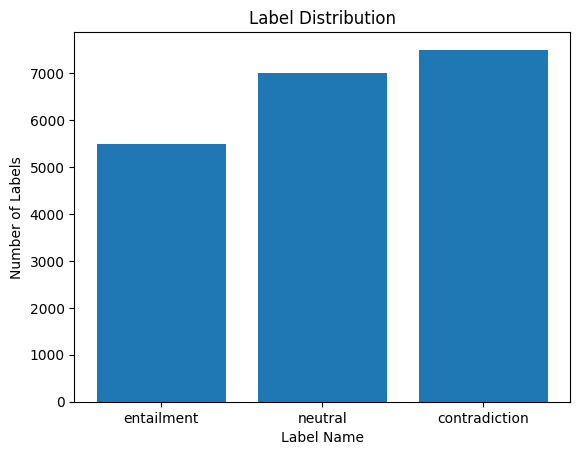

In [13]:
#Plotting the bar chart only for the TRAINING DATASET(X-Axis: "Label Name", Y-Axis: "Number of Labels")
labels = df2['gold_label'].unique()
label = df2['gold_label']
values = [0 for i in range(3)]
for j in label:
  if(j == 'contradiction'):
    values[2] += 1
  elif(j == 'entailment'):
    values[0] += 1
  else:
    values[1] += 1

plt.bar(labels, values)
plt.title('Label Distribution')
plt.xlabel('Label Name')
plt.ylabel('Number of Labels')

print(sum(values))

29842


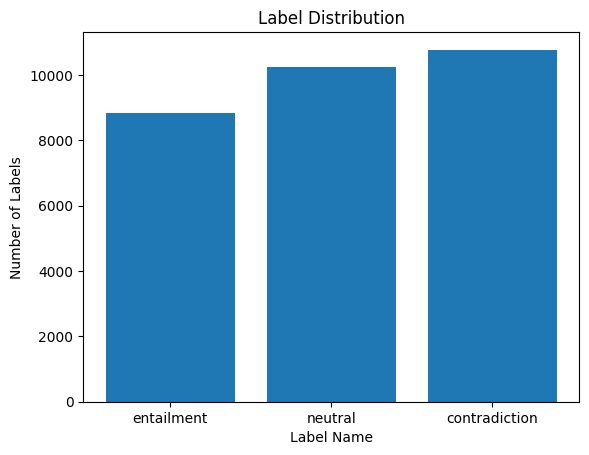

In [14]:
#Plotting the bar chart only for the TRAINING DATASET(X-Axis: "Label Name", Y-Axis: "Number of Labels")
labels = df_result['gold_label'].unique()
label = df_result['gold_label']
values = [0 for i in range(3)]
for j in label:
  if(j == 'contradiction'):
    values[2] += 1
  elif(j == 'entailment'):
    values[0] += 1
  else:
    values[1] += 1

plt.bar(labels, values)
plt.title('Label Distribution')
plt.xlabel('Label Name')
plt.ylabel('Number of Labels')

print(sum(values))

In [15]:
#Converting the labels from strings to integer values
df_result['gold_label'] = df_result['gold_label'].replace('contradiction',2)
df_result['gold_label'] = df_result['gold_label'].replace('entailment',0)
df_result['gold_label'] = df_result['gold_label'].replace('neutral',1)

In [16]:
df_result['gold_label'].unique()

array([0, 1, 2])

TOKENIZING THE DATASET

In [17]:
#Roberta Tokenizer since we are using the RoBERTs model
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

In [18]:
#Splitting the sentences from the TRAINING DATASET to tokenize them

sentence1 = df_result['sentence1'].values
sentence2 = df_result['sentence2'].values
labels = df_result.gold_label.values
print(type(sentence1), type(sentence2), type(labels))
print(len(sentence1), len(sentence2), len(labels))

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
29842 29842 29842


In [20]:
# Running this snippet to find out the max lengths of both the sentences for padding or truncating

max_len_1 = 0
max_len_2 = 0

#Running a for loop to find out the maximum lengths
for i in range(29842):

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids_1 = tokenizer.encode(sentence1[i], add_special_tokens=True)
    input_ids_2 = tokenizer.encode(sentence2[i], add_special_tokens=True)

    # Update the maximum sentence length.
    max_len_1 = max(max_len_1, len(input_ids_1))
    max_len_2 = max(max_len_2, len(input_ids_2))

print('Max sentence length: ', max_len_1 , max_len_2)

Max sentence length:  66 59


In [ ]:
# Tokenize all of the TRAINING + VALIDATION DATASET sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for i in range(29842):
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict1 = tokenizer.encode_plus(
                        sentence1[i],              # Sentence to encode.
                        sentence2[i],
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 64,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )

    # Add the encoded sentence to the list.
    input_ids.append(encoded_dict1['input_ids'])

    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict1['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)
#labels = torch.from_numpy(labels)

# Print sentence 0, now as a list of IDs.
#print('Original: ', sentence2[0])
print('Token IDs:', input_ids[0])

In [24]:
# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 80-20 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

23,873 training samples
5,969 validation samples


In [25]:
# The DataLoader needs to know our batch size for training, so we specify it
# here. For fine-tuning BERT on a specific task, the authors recommend a batch
# size of 16 or 32.
batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order.
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [26]:
model = RobertaForSequenceClassification.from_pretrained(
    'roberta-base',
    num_labels = 3,
)
model.to(device)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

In [48]:
optimizer = AdamW(model.parameters(),
                  lr = 3e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [49]:
# Number of training epochs. The BERT authors recommend between 2 and 4.
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 4

# Total number of training steps is [number of batches] x [number of epochs].
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [50]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)



def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [51]:
#Training the model
import random
# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss,
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)

            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader.
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because
        # accumulating the gradients is "convenient while training RNNs".
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()

        # Perform a forward pass (evaluate the model on this training batch).
        # In PyTorch, calling `model` will in turn call the model's `forward`
        # function and pass down the arguments. The `forward` function is
        # documented here:
        # https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification
        # The results are returned in a results object, documented here:
        # https://huggingface.co/transformers/main_classes/output.html#transformers.modeling_outputs.SequenceClassifierOutput
        # Specifically, we'll get the loss (because we provided labels) and the
        # "logits"--the model outputs prior to activation.
        result = model(b_input_ids,
                       token_type_ids=None,
                       attention_mask=b_input_mask,
                       labels=b_labels,
                       return_dict=True)

        loss = result.loss
        logits = result.logits

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)

    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))

    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:

        # Unpack this training batch from our dataloader.
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            result = model(b_input_ids,
                           token_type_ids=None,
                           attention_mask=b_input_mask,
                           labels=b_labels,
                           return_dict=True)

        # Get the loss and "logits" output by the model. The "logits" are the
        # output values prior to applying an activation function like the
        # softmax.
        loss = result.loss
        logits = result.logits

        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)


    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)

    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    747.    Elapsed: 0:00:13.
  Batch    80  of    747.    Elapsed: 0:00:26.
  Batch   120  of    747.    Elapsed: 0:00:39.
  Batch   160  of    747.    Elapsed: 0:00:53.
  Batch   200  of    747.    Elapsed: 0:01:06.
  Batch   240  of    747.    Elapsed: 0:01:20.
  Batch   280  of    747.    Elapsed: 0:01:33.
  Batch   320  of    747.    Elapsed: 0:01:47.
  Batch   360  of    747.    Elapsed: 0:02:01.
  Batch   400  of    747.    Elapsed: 0:02:14.
  Batch   440  of    747.    Elapsed: 0:02:28.
  Batch   480  of    747.    Elapsed: 0:02:41.
  Batch   520  of    747.    Elapsed: 0:02:55.
  Batch   560  of    747.    Elapsed: 0:03:08.
  Batch   600  of    747.    Elapsed: 0:03:22.
  Batch   640  of    747.    Elapsed: 0:03:35.
  Batch   680  of    747.    Elapsed: 0:03:48.
  Batch   720  of    747.    Elapsed: 0:04:02.

  Average training loss: 0.16
  Training epcoh took: 0:04:11

Running Validation...
  Accuracy: 0.85
  Validat

In [52]:
df2_test['gold_label'] = df2_test['gold_label'].replace('contradiction',2)
df2_test['gold_label'] = df2_test['gold_label'].replace('entailment',0)
df2_test['gold_label'] = df2_test['gold_label'].replace('neutral',1)

<ipython-input-52-b0deb67514b2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_test['gold_label'] = df2_test['gold_label'].replace('contradiction',2)
<ipython-input-52-b0deb67514b2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_test['gold_label'] = df2_test['gold_label'].replace('entailment',0)
<ipython-input-52-b0deb67514b2>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

In [53]:
df2_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9824 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   gold_label  9824 non-null   int64 
 1   sentence1   9824 non-null   object
 2   sentence2   9824 non-null   object
dtypes: int64(1), object(2)
memory usage: 307.0+ KB


In [54]:
# Create sentence and label lists
sentence1 = df2_test['sentence1'].values
sentence2 = df2_test['sentence2'].values
labels = df2_test.gold_label.values

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for i in range(9824):
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sentence1[i],              # Sentence to encode.
                        sentence2[i],
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 64,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )

    # Add the encoded sentence to the list.
    input_ids.append(encoded_dict['input_ids'])

    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Set the batch size.
batch_size = 32

# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2418: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowin

In [55]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables
predictions , true_labels = [], []

# Predict
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)

  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch

  # Telling the model not to compute or store gradients, saving memory and
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions.
      result = model(b_input_ids,
                     token_type_ids=None,
                     attention_mask=b_input_mask,
                     return_dict=True)

  logits = result.logits

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  pred_labels = np.argmax(logits, axis=1)
  label_ids = b_labels.to('cpu').numpy()

  # Store predictions and true labels
  predictions.extend(pred_labels.tolist())
  true_labels.extend(label_ids.tolist())

print('    DONE.')

Predicting labels for 9,824 test sentences...
    DONE.


In [56]:
from sklearn.metrics import classification_report

result_report= classification_report(true_labels, predictions, digits=3, output_dict = True)

In [58]:
print(result_report)

{'0': {'precision': 0.8974514563106796, 'recall': 0.8782660332541568, 'f1-score': 0.8877551020408162, 'support': 3368}, '1': {'precision': 0.8293209876543209, 'recall': 0.834731283007145, 'f1-score': 0.8320173401455333, 'support': 3219}, '2': {'precision': 0.8911192214111923, 'recall': 0.9051590979301822, 'f1-score': 0.8980842911877395, 'support': 3237}, 'accuracy': 0.8728623778501629, 'macro avg': {'precision': 0.8726305551253976, 'recall': 0.8727188047304946, 'f1-score': 0.8726189111246964, 'support': 9824}, 'weighted avg': {'precision': 0.8730408880111623, 'recall': 0.8728623778501629, 'f1-score': 0.8728951396759623, 'support': 9824}}


In [47]:
import os

# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = '/content/drive/MyDrive/Homework_2'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))


Saving model to /content/drive/MyDrive/Homework_2


('/content/drive/MyDrive/Homework_2/tokenizer_config.json',
 '/content/drive/MyDrive/Homework_2/special_tokens_map.json',
 '/content/drive/MyDrive/Homework_2/vocab.json',
 '/content/drive/MyDrive/Homework_2/merges.txt',
 '/content/drive/MyDrive/Homework_2/added_tokens.json')